# Deep Learning Exercise 7: Implementing Optimizers (SGD, Momentum, Adaptive LR)


In this notebook you will:

- Work with a simple fully-connected neural network (2-layer MLP).
- Train it on a **deterministic synthetic dataset**.
- Implement:
  - **Stochastic Gradient Descent (SGD)** with momentum.
  - Experiments with **different learning rates**.
  - An **adaptive learning rate optimizer** (AdaGrad).

The neural network **forward and backward passes are already implemented for you**.
You will focus on the **optimization algorithms** and on interpreting the results.

---

## Instructions

- Fill in all cells marked with **`TODO`**.
- You can run other cells to explore, print shapes, or try variations.
- Feel free to add additional plots or experiments.


> This is the **exercise** version of the notebook. There are no solutions filled in.


## 1. Setup and Imports


In [19]:

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)


## 2. Deterministic Synthetic Dataset

We'll create a simple **2D classification** problem with two classes that are not linearly separable.

- Inputs: 2D points $x \in \mathbb{R}^2$
- Targets: class labels in \{0, 1\}

We'll use a small neural network to classify these points.


In [20]:

def make_toy_data(n_per_class=200):
    """Create a deterministic 2D binary classification dataset."""
    np.random.seed(123)  # fixed seed for deterministic data

    # Class 0: points around (0, 0)
    mean0 = np.array([0.0, 0.0])
    cov0 = np.array([[0.2, 0.0],
                     [0.0, 0.2]])
    x0 = np.random.multivariate_normal(mean0, cov0, size=n_per_class)

    # Class 1: points around (1, 1)
    mean1 = np.array([1.0, 1.0])
    cov1 = np.array([[0.2, 0.0],
                     [0.0, 0.2]])
    x1 = np.random.multivariate_normal(mean1, cov1, size=n_per_class)

    X = np.vstack([x0, x1])        # shape (2 * n_per_class, 2)
    y = np.array([0] * n_per_class + [1] * n_per_class)  # shape (2 * n_per_class,)

    # Shuffle deterministically
    rng = np.random.RandomState(999)
    indices = rng.permutation(len(X))
    X = X[indices]
    y = y[indices]

    return X, y


X, y = make_toy_data(n_per_class=300)
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (600, 2)
y shape: (600,)


In [21]:

# Train/validation split
n_train = int(0.8 * len(X))
X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:], y[n_train:]

print("Train size:", X_train.shape[0])
print("Val size:", X_val.shape[0])


Train size: 480
Val size: 120


### Visualize the dataset (optional but recommended)


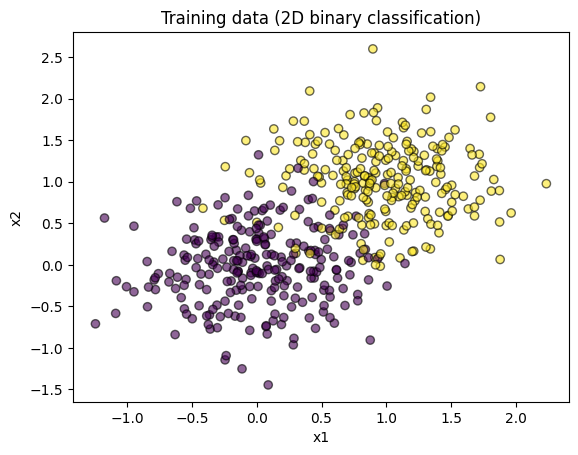

In [22]:

plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=0.6, edgecolors='k')
plt.title("Training data (2D binary classification)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


## 3. Neural Network Definition

We'll use a small **2-layer MLP**:

- Input: 2 features
- Hidden layer: `hidden_dim` units, ReLU activation
- Output layer: 2 units (logits for class 0 and 1), softmax for probabilities

The forward and backward passes are implemented for you.


In [23]:

def init_params(input_dim=2, hidden_dim=16, output_dim=2):
    """Initialize parameters of a 2-layer MLP."""
    rng = np.random.RandomState(0)
    params = {
        "W1": 0.1 * rng.randn(input_dim, hidden_dim),
        "b1": np.zeros((1, hidden_dim)),
        "W2": 0.1 * rng.randn(hidden_dim, output_dim),
        "b2": np.zeros((1, output_dim)),
    }
    return params


def relu(z):
    return np.maximum(0, z)


def relu_backward(dout, z):
    dz = dout.copy()
    dz[z <= 0] = 0
    return dz


def softmax(logits):
    logits = logits - np.max(logits, axis=1, keepdims=True)
    exp = np.exp(logits)
    return exp / np.sum(exp, axis=1, keepdims=True)


def cross_entropy_loss(probs, y_true):
    """Compute mean cross-entropy loss for integer labels."""
    N = y_true.shape[0]
    log_likelihood = -np.log(probs[np.arange(N), y_true] + 1e-12)
    return np.mean(log_likelihood)


def accuracy(probs, y_true):
    preds = np.argmax(probs, axis=1)
    return np.mean(preds == y_true)


def forward_pass(X, params):
    """Compute forward pass and return outputs + cache for backprop."""
    W1, b1 = params["W1"], params["b1"]
    W2, b2 = params["W2"], params["b2"]

    z1 = X @ W1 + b1      # (N, hidden_dim)
    h1 = relu(z1)         # (N, hidden_dim)
    logits = h1 @ W2 + b2 # (N, 2)
    probs = softmax(logits)

    cache = {"X": X, "z1": z1, "h1": h1, "logits": logits}
    return probs, cache


def backward_pass(probs, cache, params, y_true):
    """Compute gradients of loss wrt parameters."""
    X, z1, h1 = cache["X"], cache["z1"], cache["h1"]
    W1, W2 = params["W1"], params["W2"]
    N = X.shape[0]

    # dL/dlogits
    dlogits = probs.copy()
    dlogits[np.arange(N), y_true] -= 1
    dlogits /= N

    # Gradients for W2, b2
    dW2 = h1.T @ dlogits
    db2 = np.sum(dlogits, axis=0, keepdims=True)

    # Backprop into hidden layer
    dh1 = dlogits @ W2.T
    dz1 = relu_backward(dh1, z1)

    # Gradients for W1, b1
    dW1 = X.T @ dz1
    db1 = np.sum(dz1, axis=0, keepdims=True)

    grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}
    return grads


## 4. Training Loop Skeleton

Below is a generic training loop that:

- Performs forward and backward passes.
- Uses an **update function** to change parameters.
- Records loss and accuracy over time.

We provide a basic **SGD update** as an example.


In [24]:

def sgd_update(params, grads, lr):
    """Simple SGD update (provided example)."""
    for k in params.keys():
        params[k] -= lr * grads[k]
    return params


In [25]:

def train_model(
    X_train, y_train,
    X_val, y_val,
    params,
    update_fn,
    num_epochs=50,
    batch_size=64,
    lr=0.1,
    update_state=None,
):
    """Generic training loop.

    Args:
        update_fn: function(params, grads, lr, state) -> (params, state)
        update_state: any additional state used by the optimizer (e.g. momentum).
    """
    N = X_train.shape[0]
    num_batches = int(np.ceil(N / batch_size))

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    }

    if update_state is None:
        update_state = {}

    for epoch in range(num_epochs):
        # Shuffle each epoch deterministically given epoch index (for reproducibility)
        rng = np.random.RandomState(epoch)
        indices = rng.permutation(N)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        for b in range(num_batches):
            start = b * batch_size
            end = min((b + 1) * batch_size, N)
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]

            probs, cache = forward_pass(X_batch, params)
            grads = backward_pass(probs, cache, params, y_batch)

            params, update_state = update_fn(params, grads, lr, update_state)

        # End of epoch: evaluate on train & val
        train_probs, _ = forward_pass(X_train, params)
        val_probs, _ = forward_pass(X_val, params)

        train_loss = cross_entropy_loss(train_probs, y_train)
        val_loss = cross_entropy_loss(val_probs, y_val)
        train_acc = accuracy(train_probs, y_train)
        val_acc = accuracy(val_probs, y_val)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
                  f"train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")

    return params, history


In [26]:

def plot_history(history, title="Training history"):
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="train loss")
    plt.plot(epochs, history["val_loss"], label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="train acc")
    plt.plot(epochs, history["val_acc"], label="val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


## 5. Exercise 1 – Implement SGD with Momentum (3P)

We want to implement SGD with momentum:

\begin{align}
v_t &= \mu v_{t-1} - \eta \nabla_\theta L(\theta_{t-1}) \\
\theta_t &= \theta_{t-1} + v_t
\end{align}

where:

- $\mu$ is the **momentum coefficient** (e.g. 0.9)
- $\eta$ is the learning rate
- $v_t$ is the velocity (one per parameter tensor)

### Your task

- Implement the `sgd_momentum_update` function by filling the `TODO` parts.
- Use the `update_state` dictionary to store and update the velocities.


In [27]:

def sgd_momentum_update(params, grads, lr, state, momentum=0.9):
    """SGD with momentum.

    Args:
        params: dictionary of parameters
        grads: dictionary of gradients (same keys as params)
        lr: learning rate
        state: dictionary used to store optimizer state (e.g. velocities)
        momentum: momentum coefficient (e.g. 0.9)
    Returns:
        updated_params, updated_state
    """
    # TODO: initialize velocity dict in state on first call
    # Hint: use something like:
    # if "velocity" not in state:
    #     state["velocity"] = {k: np.zeros_like(v) for k, v in params.items()}
    if "velocity" not in state:
        state["velocity"] = {k: np.zeros_like(v) for k, v in params.items()}

    # TODO: update each parameter using momentum
    # Pseudocode:
    # for each param key k:
    #     v_k = momentum * v_k - lr * grad_k
    #     param_k = param_k + v_k
    v = state["velocity"]

    for k in params.keys():
        v[k] = momentum * v[k] - lr * grads[k]
        params[k] = params[k] + v[k]

    return params, state


### Try your momentum implementation

Use the helper training loop with your `sgd_momentum_update` and compare it later
with plain SGD and adaptive methods.


Epoch   1: train_loss=0.5789, val_loss=0.5765, train_acc=0.829, val_acc=0.825
Epoch  10: train_loss=0.1597, val_loss=0.1012, train_acc=0.938, val_acc=0.975
Epoch  20: train_loss=0.1568, val_loss=0.1057, train_acc=0.935, val_acc=0.975
Epoch  30: train_loss=0.1556, val_loss=0.1015, train_acc=0.938, val_acc=0.983
Epoch  40: train_loss=0.1529, val_loss=0.1025, train_acc=0.938, val_acc=0.975
Epoch  50: train_loss=0.1519, val_loss=0.1015, train_acc=0.938, val_acc=0.975
Epoch  60: train_loss=0.1562, val_loss=0.1036, train_acc=0.938, val_acc=0.975
Epoch  70: train_loss=0.1507, val_loss=0.1038, train_acc=0.940, val_acc=0.975
Epoch  80: train_loss=0.1510, val_loss=0.1106, train_acc=0.929, val_acc=0.967


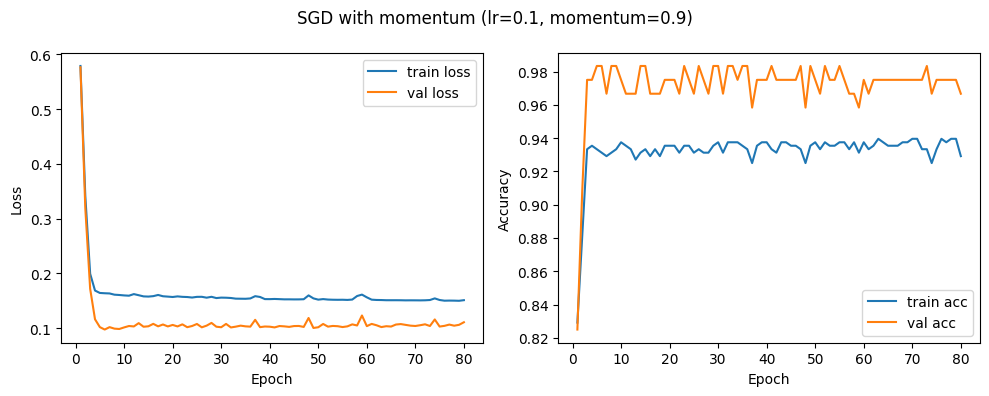

In [28]:

# TODO: uncomment and run after implementing sgd_momentum_update

params = init_params()
params, history_mom = train_model(
    X_train, y_train,
    X_val, y_val,
    params,
    update_fn=sgd_momentum_update,
    num_epochs=80,
    batch_size=64,
    lr=0.1,
    update_state=None,
)
plot_history(history_mom, title="SGD with momentum (lr=0.1, momentum=0.9)")


In [29]:

# Sanity check for SGD with momentum (deterministic)
# Run this AFTER training with `sgd_momentum_update` to verify your results.

expected_val_loss_mom = 0.11064457994222818
expected_val_acc_mom = 0.9666666666666667

print("Your final validation loss:", history_mom["val_loss"][-1])
print("Your final validation accuracy:", history_mom["val_acc"][-1])

assert np.isclose(history_mom["val_loss"][-1], expected_val_loss_mom, atol=1e-3)
assert np.isclose(history_mom["val_acc"][-1], expected_val_acc_mom, atol=1e-3)

print("Sanity check passed! Your momentum implementation matches the reference behavior (within tolerance).")


Your final validation loss: 0.11064457994222819
Your final validation accuracy: 0.9666666666666667
Sanity check passed! Your momentum implementation matches the reference behavior (within tolerance).


## 6. Exercise 2 – Compare Different Learning Rates (2P)

Now let's explore how the **learning rate** affects training with **plain SGD**.

### Your task

- Complete the loop below to train several models with different learning rates.
- Store the training histories in a dictionary.
- Plot and compare losses and accuracies.


In [35]:

learning_rates = [0.001, 0.01, 0.1, 0.5]
histories_sgd = {}

# TODO: train a model for each learning rate using plain SGD
# Hint:  use sgd_update inside a small wrapper so it matches the (params, grads, lr, state) -> (params, state) signature
# Example:
# def sgd_update_wrapper(params, grads, lr, state):
#     return sgd_update(params, grads, lr), state
def sgd_update_wrapper(params, grads, lr, state):
    return sgd_update(params, grads, lr), state

for lr in learning_rates:
    params = init_params()
    params, history_sgd = train_model(X_train, y_train, X_val, y_val, params, update_fn=sgd_update_wrapper, num_epochs=60, lr=lr, update_state=None)
    histories_sgd[lr] = history_sgd



Epoch   1: train_loss=0.6940, val_loss=0.6946, train_acc=0.467, val_acc=0.467
Epoch  10: train_loss=0.6914, val_loss=0.6920, train_acc=0.521, val_acc=0.567
Epoch  20: train_loss=0.6886, val_loss=0.6892, train_acc=0.562, val_acc=0.608
Epoch  30: train_loss=0.6857, val_loss=0.6863, train_acc=0.594, val_acc=0.625
Epoch  40: train_loss=0.6829, val_loss=0.6834, train_acc=0.610, val_acc=0.625
Epoch  50: train_loss=0.6800, val_loss=0.6805, train_acc=0.627, val_acc=0.642
Epoch  60: train_loss=0.6770, val_loss=0.6776, train_acc=0.671, val_acc=0.717
Epoch   1: train_loss=0.6914, val_loss=0.6919, train_acc=0.519, val_acc=0.567
Epoch  10: train_loss=0.6643, val_loss=0.6649, train_acc=0.785, val_acc=0.783
Epoch  20: train_loss=0.6234, val_loss=0.6235, train_acc=0.842, val_acc=0.867
Epoch  30: train_loss=0.5743, val_loss=0.5730, train_acc=0.850, val_acc=0.875
Epoch  40: train_loss=0.5221, val_loss=0.5189, train_acc=0.865, val_acc=0.883
Epoch  50: train_loss=0.4726, val_loss=0.4672, train_acc=0.877, 

In [36]:

# Sanity check for plain SGD learning-rate experiments (deterministic)
# Run this AFTER you have filled in and run the loop that populates `histories_sgd`.

expected_sgd_results = {
    0.001: {"val_loss": 0.6775832785501521, "val_acc": 0.7166666666666667},
    0.01:  {"val_loss": 0.4216655110019785, "val_acc": 0.9166666666666666},
    0.1:   {"val_loss": 0.11277136265534196, "val_acc": 0.9833333333333333},
    0.5:   {"val_loss": 0.10217064812271372, "val_acc": 0.975},
}

for lr, expected in expected_sgd_results.items():
    val_loss = histories_sgd[lr]["val_loss"][-1]
    val_acc = histories_sgd[lr]["val_acc"][-1]
    print(f"lr={lr}: val_loss={val_loss:.6f}, val_acc={val_acc:.6f}")
    assert np.isclose(val_loss, expected["val_loss"], atol=1e-3)
    assert np.isclose(val_acc, expected["val_acc"], atol=1e-3)

print("Sanity check passed! Your SGD runs match the reference behavior (within tolerance).")


lr=0.001: val_loss=0.677583, val_acc=0.716667
lr=0.01: val_loss=0.421666, val_acc=0.916667
lr=0.1: val_loss=0.112771, val_acc=0.983333
lr=0.5: val_loss=0.102171, val_acc=0.975000
Sanity check passed! Your SGD runs match the reference behavior (within tolerance).


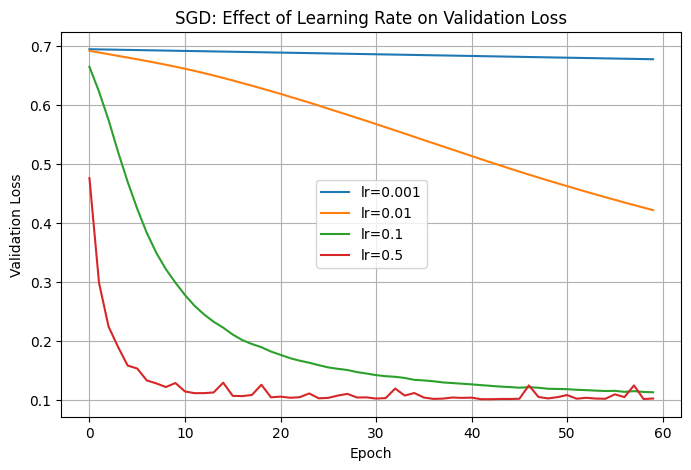

In [37]:

# TODO: plot and compare the validation loss curves for each learning rate.
# Hint: iterate over histories_sgd.items()
plt.figure(figsize=(8, 5))

for lr, history in histories_sgd.items():
    plt.plot(history["val_loss"], label=f"lr={lr}")

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("SGD: Effect of Learning Rate on Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


## 7. Exercise 3 – Adaptive Learning Rate (AdaGrad) (2P)

Finally, let's implement a simple **adaptive learning rate optimizer**: **AdaGrad**.

For each parameter \(\theta\) with gradient \(g_t\), AdaGrad keeps a running sum of squared gradients:

\begin{align}
G_t &= G_{t-1} + g_t^2 \\
\theta_t &= \theta_{t-1} - \frac{\eta}{\sqrt{G_t} + \varepsilon} g_t
\end{align}

where \(\varepsilon\) is a small constant for numerical stability (e.g. 1e-8).

### Your task

- Implement the `adagrad_update` function by filling in the `TODO`s.
- Use the `state` dictionary to store \(G_t\) (the accumulated squared gradients).


In [38]:

def adagrad_update(params, grads, lr, state, eps=1e-8):
    """AdaGrad optimizer.

    Args:
        params: dictionary of parameters
        grads: dictionary of gradients
        lr: global learning rate
        state: dictionary used to store optimizer state (e.g. accumulated squared grads)
    """
    # TODO: initialize G in state on first call
    # Hint: use something like:
    # if "G" not in state:
    #     state["G"] = {k: np.zeros_like(v) for k, v in params.items()}
    if "G" not in state:
        state["G"] = {k: np.zeros_like(v) for k, v in params.items()}

    G = state["G"]

    # TODO: for each parameter k:
    #   - accumulate squared gradients
    #   - compute effective step size lr / (sqrt(G_k) + eps)
    #   - update params
    for k in params.keys():
        # Accumulate squared gradients
        G[k] += grads[k] ** 2

        # Compute adaptive step size
        step = lr / (np.sqrt(G[k]) + eps)

        # Parameter update
        params[k] -= step * grads[k]

    return params, state


Epoch   1: train_loss=0.2124, val_loss=0.1732, train_acc=0.904, val_acc=0.925
Epoch  10: train_loss=0.1637, val_loss=0.1148, train_acc=0.931, val_acc=0.950
Epoch  20: train_loss=0.1545, val_loss=0.0983, train_acc=0.935, val_acc=0.983
Epoch  30: train_loss=0.1523, val_loss=0.1000, train_acc=0.938, val_acc=0.975
Epoch  40: train_loss=0.1509, val_loss=0.1041, train_acc=0.935, val_acc=0.967
Epoch  50: train_loss=0.1484, val_loss=0.1065, train_acc=0.940, val_acc=0.975
Epoch  60: train_loss=0.1470, val_loss=0.1057, train_acc=0.935, val_acc=0.967
Epoch  70: train_loss=0.1471, val_loss=0.1056, train_acc=0.940, val_acc=0.975
Epoch  80: train_loss=0.1507, val_loss=0.1167, train_acc=0.935, val_acc=0.958


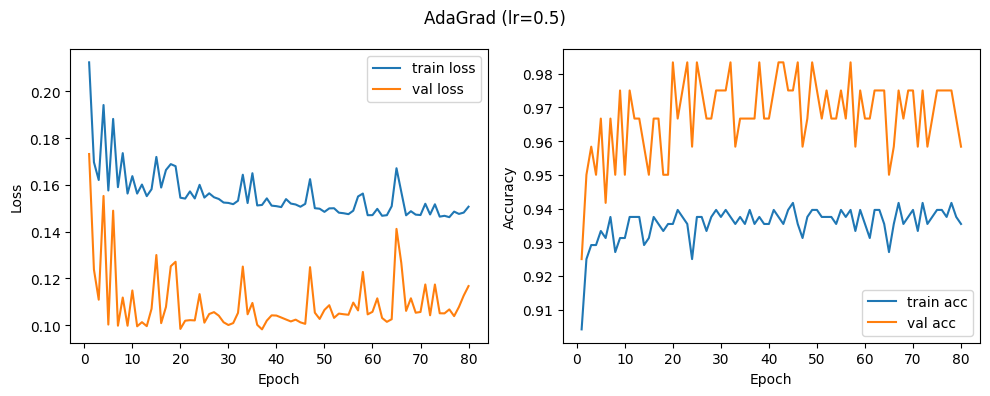

In [39]:

# TODO: train a model using your AdaGrad implementation and compare with SGD / momentum

# Example skeleton:
# params = init_params()
# params, history_adagrad = train_model(
#     X_train, y_train,
#     X_val, y_val,
#     params,
#     update_fn=adagrad_update,
#     num_epochs=80,
#     batch_size=64,
#     lr=0.5,
#     update_state=None,
# )a
# plot_history(history_adagrad, title="AdaGrad (lr=0.5)")
params = init_params()
params, history_adagrad = train_model(
    X_train, y_train,
    X_val, y_val,
    params,
    update_fn=adagrad_update,
    num_epochs=80,
    batch_size=64,
    lr=0.5,
    update_state=None,
)

plot_history(history_adagrad, title="AdaGrad (lr=0.5)")


In [40]:

# Sanity check for AdaGrad optimizer (deterministic)
# Run this AFTER training with `adagrad_update` and storing the history in `history_adagrad`.

expected_val_loss_adagrad = 0.11668241755149696
expected_val_acc_adagrad = 0.9583333333333334

print("Your final validation loss:", history_adagrad["val_loss"][-1])
print("Your final validation accuracy:", history_adagrad["val_acc"][-1])

assert np.isclose(history_adagrad["val_loss"][-1], expected_val_loss_adagrad, atol=1e-3)
assert np.isclose(history_adagrad["val_acc"][-1], expected_val_acc_adagrad, atol=1e-3)

print("Sanity check passed! Your AdaGrad implementation matches the reference behavior (within tolerance).")


Your final validation loss: 0.11668241755149693
Your final validation accuracy: 0.9583333333333334
Sanity check passed! Your AdaGrad implementation matches the reference behavior (within tolerance).


## 8. Wrap-up Questions (for reflection) (3P)

1. How does **momentum** change the training dynamics compared to plain SGD?
2. For plain SGD, which learning rates worked best? Which ones diverged or trained very slowly?
3. How does **AdaGrad** behave over time? Do you notice the learning rate effectively shrinking?

Feel free to extend this notebook with more experiments!


## 8. Answers

### 1.
Momentum adds an additional “velocity” term that accumulates past gradients.  
This creates two effects:

- **Faster progress in consistent directions:** if the gradient keeps pointing the same way, momentum amplifies updates and accelerates learning.
- **Damping of oscillations:** in directions where gradients change sign, momentum smooths the updates and reduces zig-zagging.

Overall, momentum makes training more stable, faster, and less sensitive to small local variations compared to plain SGD.

### 2.
- **Very small learning rates (e.g. 0.001)** trained extremely slowly. Loss decreased, but accuracy stayed much lower than for better learning rates.
- **Moderate learning rates (0.01 and 0.1)** worked best. They reached low validation loss and high accuracy.
- **High learning rate (0.5)** still trained but showed more instability. It converged, but the curve oscillated more and is much more sensitive to randomness.

### 3.
Yes. AdaGrad keeps a running sum of squared gradients.  
As this sum grows, the update rule causes the effective learning rate to shrink over time.

As a result:
- Early training steps are large (fast progress).
- Later steps become extremely small (learning slows down).
- Eventually, AdaGrad often stalls because the denominator grows too much.

This is why AdaGrad improves early training but can stop improving later unless the task is simple or sparse.